# MNIST Classification

**Import packages**

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Define a fully connected Neural Network
We define a very simple fully connected neural network. It is a subclass of torch.nn.Module. <br>
When extending torch.nn.Module we need to define two methods:
- `__init__` method:
it is the constructor of the class and is called only once, when instantiating the neural network. It initializes the network's architecture by initializing all network layers and other components. It is where you define the structure of the network, such as layers, activation functions, and any other components required for computation.
-`forward` method
is called when you pass input data through the network. The forward method specifies the sequence of operations that are applied to the input data. It describes how the input data flow through the various layers to produce the final output.

In [2]:
# define neural network
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()

        self.lin1 = nn.Linear(28*28, 512)
        self.act1 = nn.ReLU()

        self.lin2 = nn.Linear(512, 512)
        self.act2 = nn.ReLU()

        self.output_layer = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.flatten(x)  # (batch_size, 28, 28) => (batch_size, 28*28)

        # first layer (input is x, output is x1)
        x1 = self.lin1(x)
        x1 = self.act1(x1)

        # second layer (input is x1, output is x2)
        x2 = self.lin2(x1)
        x2 = self.act2(x2)

        # third/output layer (input is x2, output is logits)
        logits = self.output_layer(x2)
        return logits


## Dataset

In [3]:
from torchvision import datasets, transforms

# preprocessing to apply on each data sample:
# 1) convert to tensor
# 2) normalize images
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))  # Normalize a tensor image with mean and standard deviation.
        ])

# train dataset
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
print(f"MNIST train dataset - num samples: {len(train_dataset)}")

# test dataset
test_dataset = datasets.MNIST('../data', train=False, transform=transform)
print(f"MNIST test dataset - num samples: {len(test_dataset)}")

100%|██████████| 9912422/9912422 [00:00<00:00, 219574174.63it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 62473282.01it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44647458.98it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21285507.00it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

MNIST train dataset - num samples: 60000
MNIST test dataset - num samples: 10000


### Plot one sample from dataset

In [4]:
image, label = train_dataset[100]

In [5]:
image.shape

torch.Size([1, 28, 28])

In [6]:
label

5

In [7]:
# dataset returns one sample at a time
# In our case one sample corresponds to a Tuple: (Image, Target Label)
# Image is a tensor with shape [1, 28, 28]
# Label is an integer representing the class of the image

print(type(train_dataset[100]))
print(len(train_dataset[100]))

image, label = train_dataset[100]
print("image: ", image.shape, type(image))
print("label: ", label, type(label))

<class 'tuple'>
2
image:  torch.Size([1, 28, 28]) <class 'torch.Tensor'>
label:  5 <class 'int'>


In [8]:
image.shape

torch.Size([1, 28, 28])

In [9]:
image[0].shape

torch.Size([28, 28])

In [10]:
image = image.view(28,28)
image.shape

torch.Size([28, 28])

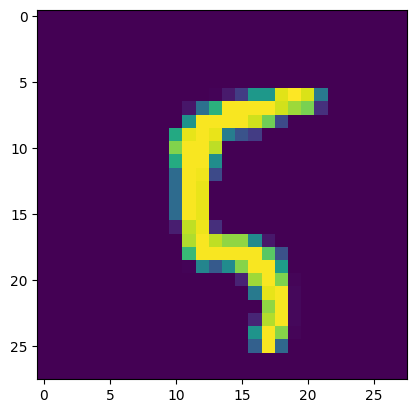

In [11]:
# plot one sample normalized

import matplotlib.pyplot as plt
plt.imshow(image.numpy())  # numpy array 28x28

## Dataloader
Dataloader reads from the dataset and returns batches of data. We need to specify at least:
- `dataset`: torch.utils.data.Dataset object from which the DataLoader fetch data
- `batch_size`: number of sample in a batch, e.g. 128, choose the maximum that the GPU can fit

Other parameters are:
- `shuffle`: boolean, whether we want to shuffle the data samples
- `drop_last`: boolean, whether the last batch, which may have fewer samples than the specified batch size, should be included or dropped



In [12]:
batch_size = 128  # we define here the batch size: number of samples processed before the model is updated
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # , drop_last=False)
print(f"batch size: {batch_size}")

batch size: 128


## Training

In [13]:
# function for training
def train(model, device, train_loader, optimizer, epoch):
    model.train()  # model to train mode

    # ITERATE DATALOADER: train_loader
    for batch_idx, (data, target) in enumerate(train_loader):
        #  SINGLE OPTIMIZATION STEP IS PERFORMED ON A BATCH!
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)

        loss = F.cross_entropy(output, target)

        loss.backward()

        optimizer.step()

        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


# test
# function for evaluation
def test(model, device, test_loader):
    model.eval()  # model to eval
    test_loss = 0
    correct = 0

    # ITERATE DATALOADER: test_loader
    for data, target in test_loader:
        batch_size = data.shape[0]
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        # sanity check
        pred = pred.view(batch_size)  # [bs,]
        target = target.view(batch_size)  # [bs,]

        # compute prediction ok
        batch_pred_ok = pred.eq(target).sum().item()
        correct += batch_pred_ok

    test_loss /= len(test_loader.dataset)
    num_samples = len(test_loader.dataset)
    test_accuracy = correct / num_samples
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
device = torch.device('cuda')  # use gpu, is equivalent to .cuda()

# training hyperparameters
lr = 0.01
num_epochs = 5
print(f"lr: {lr}")
print(f"batch size: {batch_size}")
print(f"Num. optimization steps per-epoch: {int(len(train_dataset)/batch_size)}")

#########
# MODEL #
#########
model = NeuralNetwork(num_classes=10)
model = model.to(device)

#############
# OPTIMIZER #
#############
parameters_to_optimize = model.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=0.9)

lr: 0.01
batch size: 128
Num. optimization steps per-epoch: 468


In [15]:
%%time
for epoch in range(1, num_epochs + 1):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304910
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.496038
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.503941
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.367268
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.298520
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.280180
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.162909
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.320560
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.268460
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.163087

Test set: Average loss: 0.1778, Accuracy: 9465/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.309839
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.202926
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.139450
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.116399
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.203200
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.136178
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.149274
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.237649
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.043020
T